In [1]:
import math
import os
import copy
import time
import warnings
import torch

from tempfile import TemporaryDirectory
from typing import Tuple
from typing import List
from typing import Optional, Tuple
from typing import Optional, Any, Union, Callable

from torch import nn, Tensor
from torch.nn import functional as F
from torch.utils.data import dataset
from transformers import PreTrainedModel
from torch.nn.modules.linear import NonDynamicallyQuantizableLinear
from torch.nn.init import constant_, xavier_normal_, xavier_uniform_
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.nn.modules.container import ModuleList
from torch.nn.modules.dropout import Dropout
from torch.nn.modules.linear import Linear
from torch.nn.modules.normalization import LayerNorm
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from transformers import PretrainedConfig
from transformers import OpenAIGPTConfig, AutoTokenizer, OpenAIGPTLMHeadModel 

from datasets import load_dataset
import matplotlib.pyplot as plt
import common_utils

In [100]:
# model = torch.load("/private/home/yuandong/luckmatters/ssl/real-dataset/model.pt")
model = torch.load("/private/home/yuandong/luckmatters/ssl/real-dataset/model69_train0.99_test0.01.pt")
# model = torch.load("/private/home/yuandong/luckmatters/ssl/real-dataset/model129_train1.00_test0.50.pt")
model = torch.load("/private/home/yuandong/luckmatters/ssl/real-dataset/model249_train1.00_test1.00.pt")

In [101]:
U = model["layer1.weight"].cpu()
V = model["output_layers.0.weight"].cpu()

In [102]:
# Construct fourier bases and check the norm
M = U.shape[1] // 2

x = torch.arange(M)
xx = torch.outer(x, x)
cos_mat = (xx * 2*math.pi / M).cos()
sin_mat = (xx * 2*math.pi / M).sin()


In [103]:
num_hiddens = U.shape[0]
M = U.shape[1] // 2

indices = []
all_entropies = []
for i in range(num_hiddens):
    if U[i, :M].norm() > 1e-5:
        indices.append(i)
        
    real_proj = U[i, :M] @ cos_mat
    imag_proj = U[i, :M] @ sin_mat
    # energy
    energy = real_proj**2 + imag_proj**2
    energy = energy / energy.sum()
    entropy = -(energy * (energy + 1e-8).log()).sum()
    print(f"{i}: {entropy}")
    
    all_entropies.append(entropy)
    
print(f"avg_entropy: {sum(all_entropies) / len(indices)}")
print(f"maximal_entropy: {math.log(M)}")
        
print(f"{len(indices)}/{num_hiddens} valid filters")

0: 0.8241607546806335
1: 3.8643441200256348
2: 0.7982880473136902
3: 0.8119615912437439
4: 0.8815411925315857
5: 0.9287899732589722
6: 0.7530891299247742
7: 3.795747995376587
8: 0.7821195721626282
9: 0.8179131150245667
10: 0.9553275108337402
11: 0.7212401032447815
12: 3.7996397018432617
13: 0.9435115456581116
14: 0.734775185585022
15: 1.1900737285614014
16: 0.8295479416847229
17: 0.8350738883018494
18: 0.8527326583862305
19: 0.7337875962257385
20: 3.5334649085998535
21: 2.0306789875030518
22: 0.9602880477905273
23: 0.725728452205658
24: 3.6210615634918213
25: 0.7302034497261047
26: 0.7351329326629639
27: 0.9826276302337646
28: 0.7358648777008057
29: 0.8415893316268921
30: 0.9017388224601746
31: 0.7519312500953674
32: 1.2248914241790771
33: 0.7368066906929016
34: 0.7626473903656006
35: 0.7278441190719604
36: 2.090848445892334
37: 1.006168246269226
38: 0.9014608860015869
39: 0.8171060085296631
40: 3.729400396347046
41: 3.412217378616333
42: 0.728679895401001
43: 0.863547682762146
44: 0.8

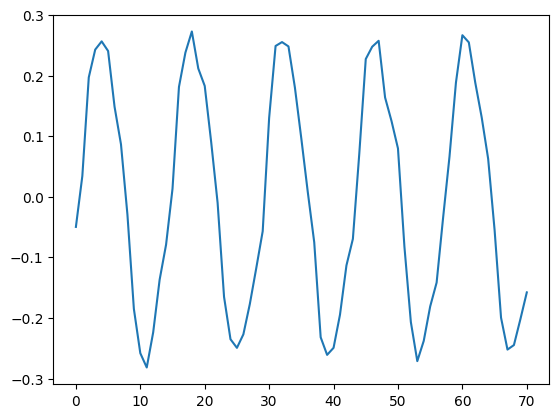

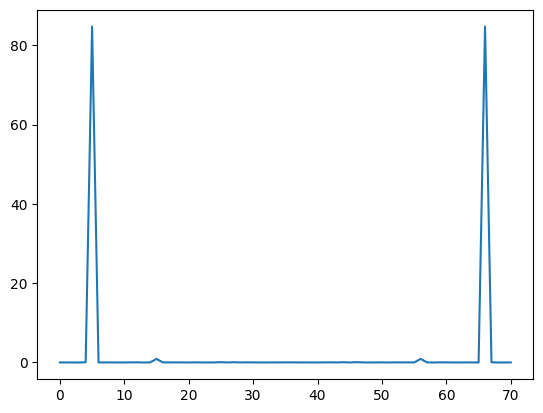

In [112]:
i = 9

plt.plot(U[i, :M])
plt.show()

real_proj = U[i, :M] @ cos_mat
imag_proj = U[i, :M] @ sin_mat

plt.plot(real_proj**2 + imag_proj**2)
plt.show()

128/128 valid filters


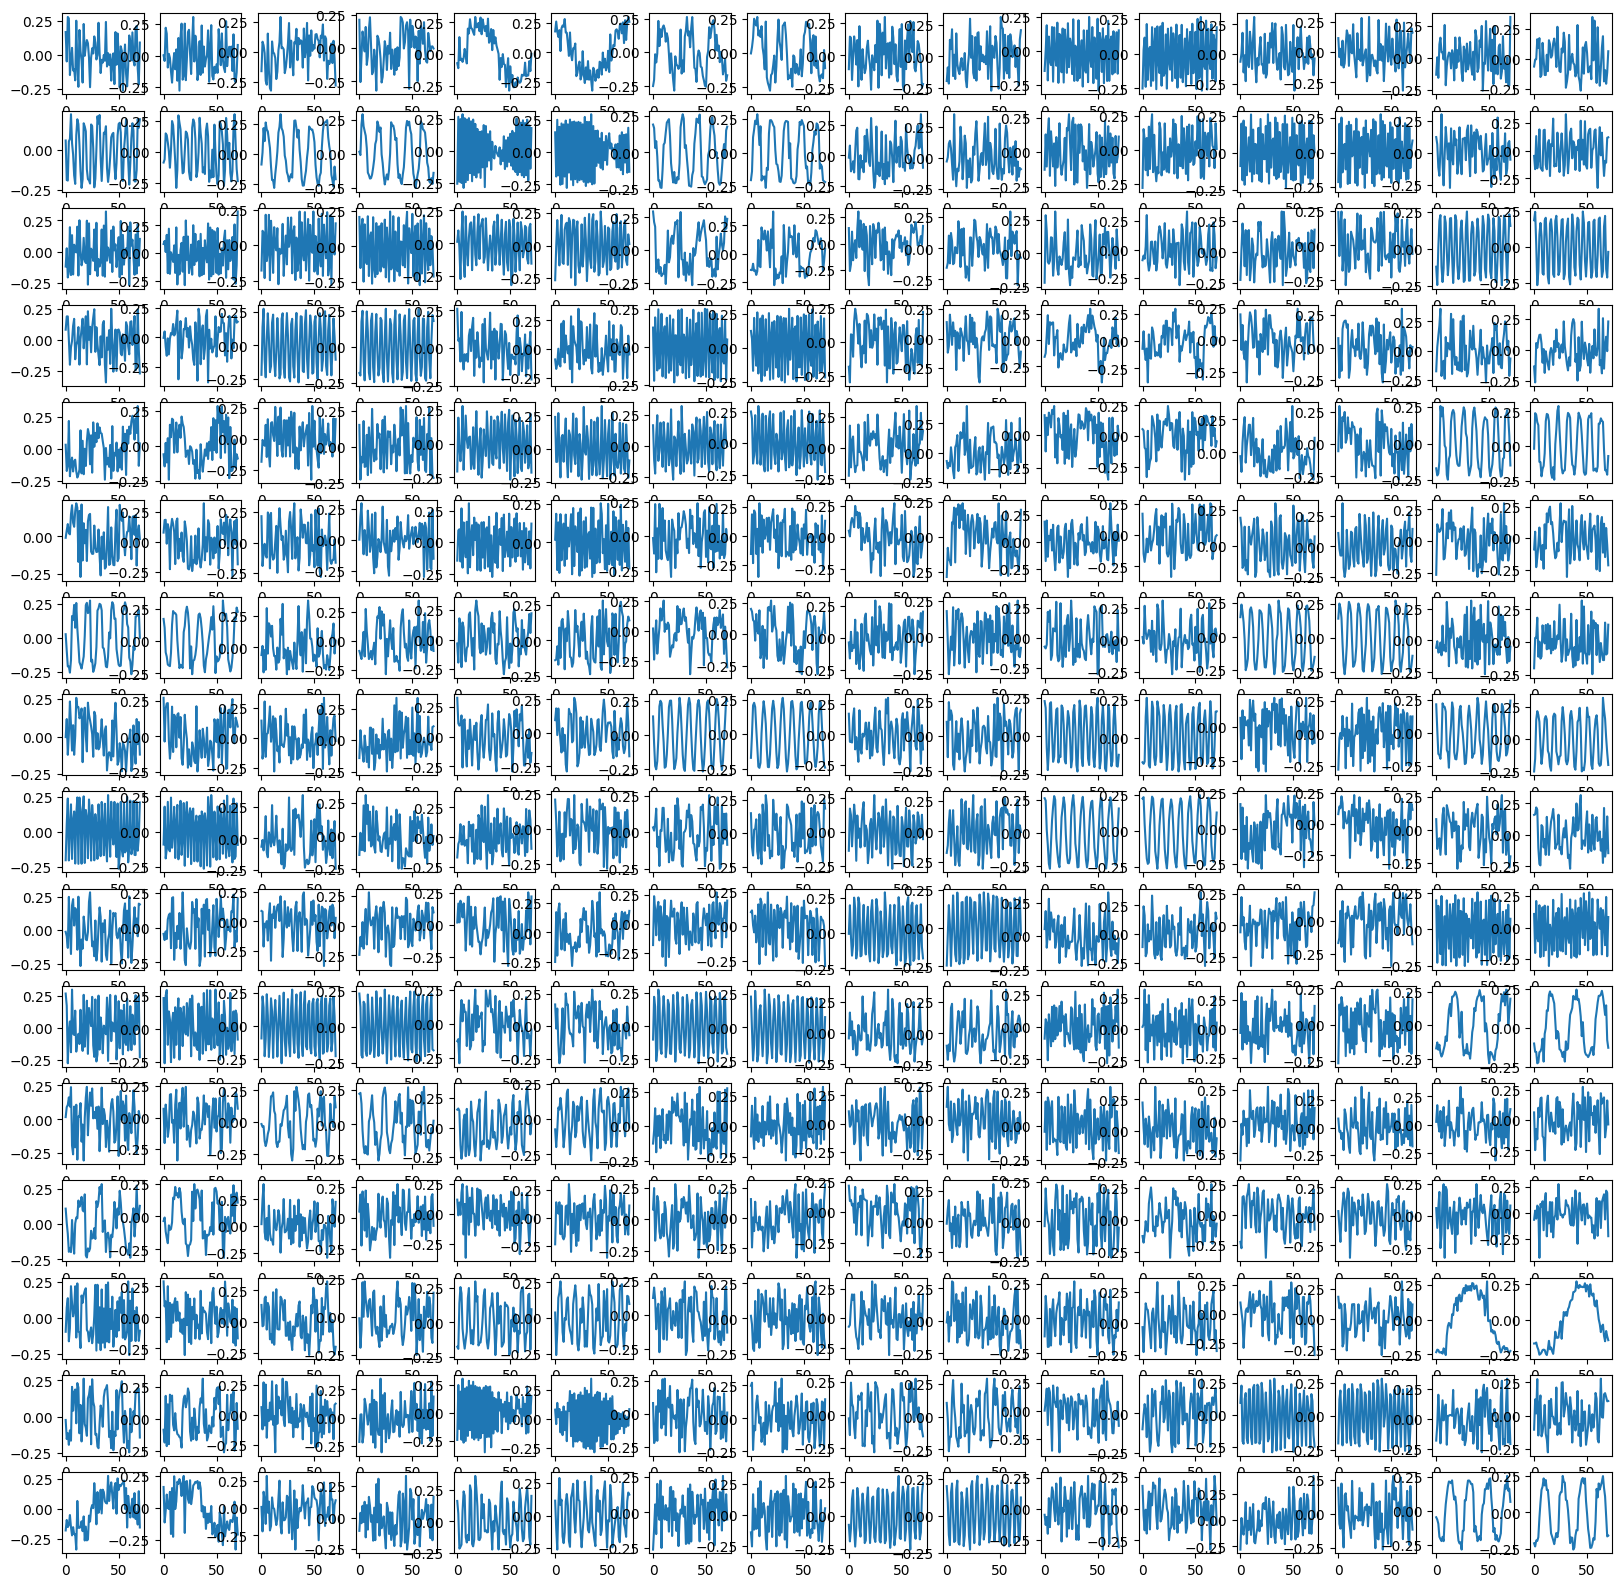

In [86]:
import math

plt.figure(figsize=(20, 20))
        
num_cols = math.ceil(math.sqrt(len(indices) * 2))
num_rows = math.ceil(len(indices) * 2 / num_cols)
        
for i, ii in enumerate(indices):
    plt.subplot(num_rows, num_cols, 2*i + 1)
    plt.plot(U[ii, :M])
    plt.subplot(num_rows, num_cols, 2*i + 2)
    plt.plot(U[ii, M:])

In [74]:
U.norm(dim=1)

tensor([2.0360, 2.0214, 2.0204, 2.0947, 2.3335, 2.0307, 1.9868, 2.3396, 2.3488,
        2.1752, 2.1903, 2.0374, 2.3705, 2.2968, 2.0299, 2.1207, 2.3877, 2.0302,
        2.3413, 2.0196, 2.1363, 2.0916, 2.0329, 2.0260, 2.4148, 2.3659, 1.8472,
        2.0257, 2.3682, 2.1140, 2.0624, 2.0260, 2.3781, 2.3013, 2.0323, 2.0220,
        2.0261, 2.0928, 2.3760, 2.3360, 2.0272, 2.0330, 2.0242, 2.0268, 2.0196,
        2.0266, 2.3917, 2.1710, 2.3869, 2.0337, 2.1630, 2.0284, 2.3795, 2.3630,
        2.0112, 2.1095, 2.0224, 2.0197, 2.1351, 1.5070, 2.0301, 2.4803, 2.3528,
        2.3799, 2.0185, 2.0239, 2.1100, 2.3191, 2.8019, 2.0208, 1.7374, 2.3342,
        1.0454, 2.8076, 2.0911, 2.1037, 2.0329, 2.2981, 2.8016, 2.0870, 2.0222,
        1.3519, 1.6003, 2.4819, 2.3798, 2.1553, 2.0201, 2.0774, 2.3432, 2.6163,
        2.3666, 2.8005, 2.3423, 2.0299, 2.0292, 2.8238, 2.0312, 1.3101, 1.9895,
        2.2658, 2.1873, 2.8282, 2.4699, 2.4692, 2.3399, 2.3233, 2.0193, 1.8407,
        2.2705, 2.2809, 2.0202, 2.0190, 

In [29]:
V.shape

torch.Size([127, 128])

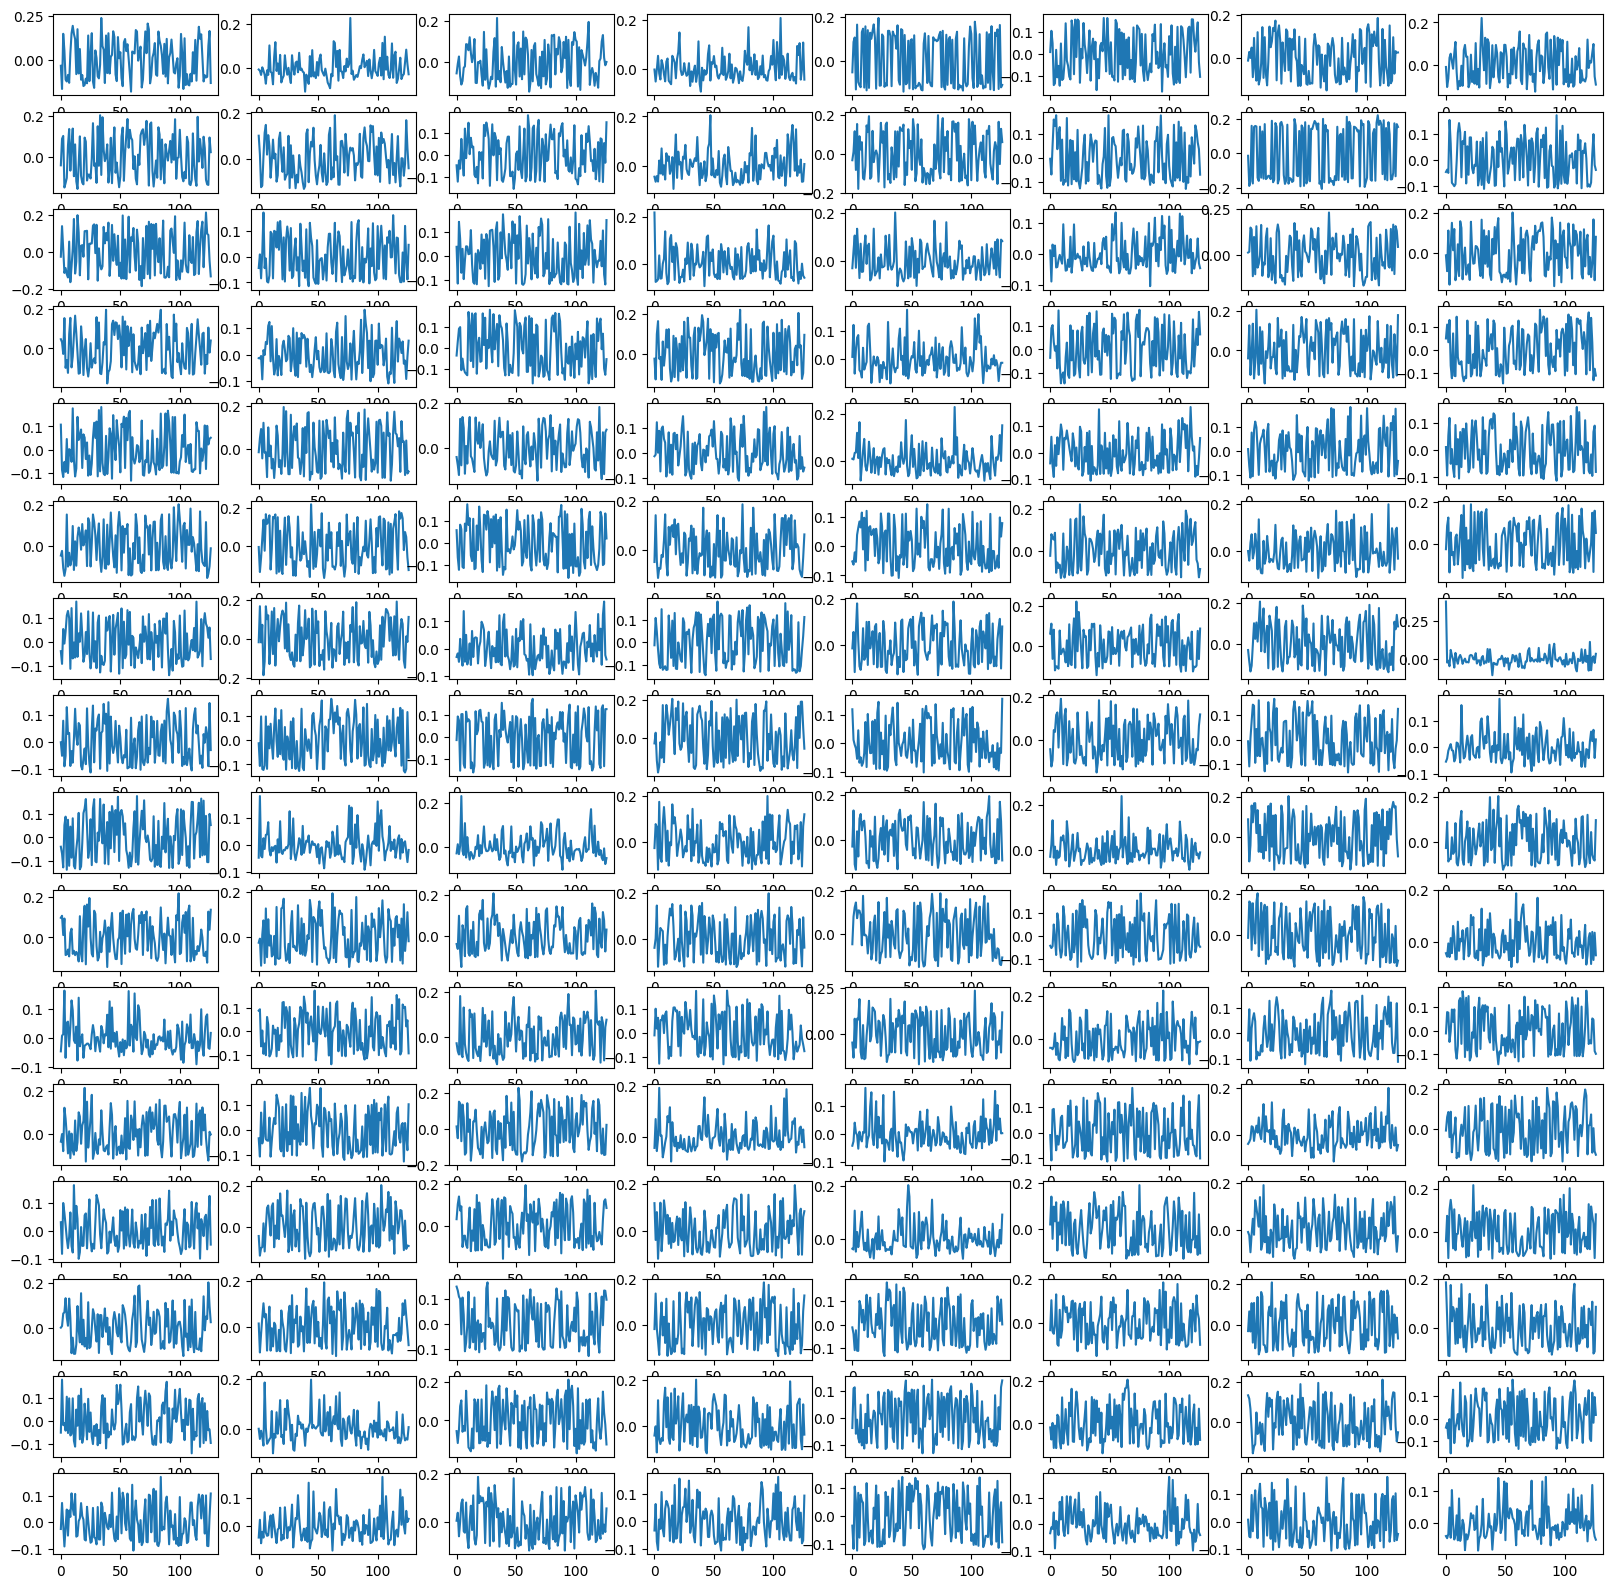

In [31]:
plt.figure(figsize=(20, 20))
for i in range(128):
    plt.subplot(16, 8, i + 1)
    plt.plot(V[:127, i])